# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#Random Seed
random.seed(47)

# -------------------- Port Traffic Control -------------------
#### Create the DataFrame for port traffic control

In [2]:
df_traffic_control = pd.DataFrame({
    'Vessel_ID': [f'V{i:04d}' for i in range(1, 1001)],
    'Timestamp_Entry': [datetime.now() - timedelta(hours=random.randint(1, 800)) for _ in range(1000)],
    'Timestamp_Exit': [datetime.now() + timedelta(hours=random.randint(1, 800)) for _ in range(1000)],
    'Containers_Unloaded (TEUs)': [random.randint(20, 4578) for _ in range(1000)],
    'Containers_Loaded (TEUs)': [random.randint(20, 4543) for _ in range(1000)]
})

# Add 'Time' column by calculating the difference between 'Timestamp_Exit' and 'Timestamp_Entry'
df_traffic_control['Time'] = df_traffic_control['Timestamp_Exit'] - df_traffic_control['Timestamp_Entry']

# Convert 'Time' column to hours and store in a new column 'Time_in_Hours'
df_traffic_control['Time_in_Hours'] = df_traffic_control['Time'].dt.total_seconds() / 3600

# Extract the day from the timestamps
df_traffic_control['Entry_Day'] = df_traffic_control['Timestamp_Entry'].dt.day
df_traffic_control['Exit_Day'] = df_traffic_control['Timestamp_Exit'].dt.day

df_traffic_control



,Vessel_ID,Timestamp_Entry,Timestamp_Exit,Containers_Unloaded (TEUs),Containers_Loaded (TEUs),Time,Time_in_Hours,Entry_Day,Exit_Day
0,V0001,2023-09-16 14:01:03.620538,2023-11-02 02:01:03.626816,3021,3745,46 days 12:00:00.006278,1116.000002,16,2
1,V0002,2023-09-28 22:01:03.620538,2023-10-30 03:01:03.626816,3156,2759,31 days 05:00:00.006278,749.000002,28,30
2,V0003,2023-09-13 06:01:03.620538,2023-10-17 20:01:03.626816,1597,1979,34 days 14:00:00.006278,830.000002,13,17
3,V0004,2023-09-08 00:01:03.620538,2023-10-12 23:01:03.626816,4096,1416,34 days 23:00:00.006278,839.000002,8,12
4,V0005,2023-09-12 06:01:03.620538,2023-11-03 08:01:03.626816,597,2847,52 days 02:00:00.006278,1250.000002,12,3
...,...,...,...,...,...,...,...,...,...
995,V0996,2023-09-22 06:01:03.626816,2023-10-09 13:01:03.628034,953,1884,17 days 07:00:00.001218,415.000000,22,9
996,V0997,2023-09-29 02:01:03.626816,2023-10-08 20:01:03.628034,3668,1422,9 days 18:00:00.001218,234.000000,29,8
997,V0998,2023-09-18 00:01:03.626816,2023-10-20 23:01:03.628034,3940,3861,32 days 23:00:00.001218,791.000000,18,20
998,V0999,2023-09-18 11:01:03.626816,2023-10-04 14:01:03.628034,2645,2884,16 days 03:00:00.001218,387.000000,18,4


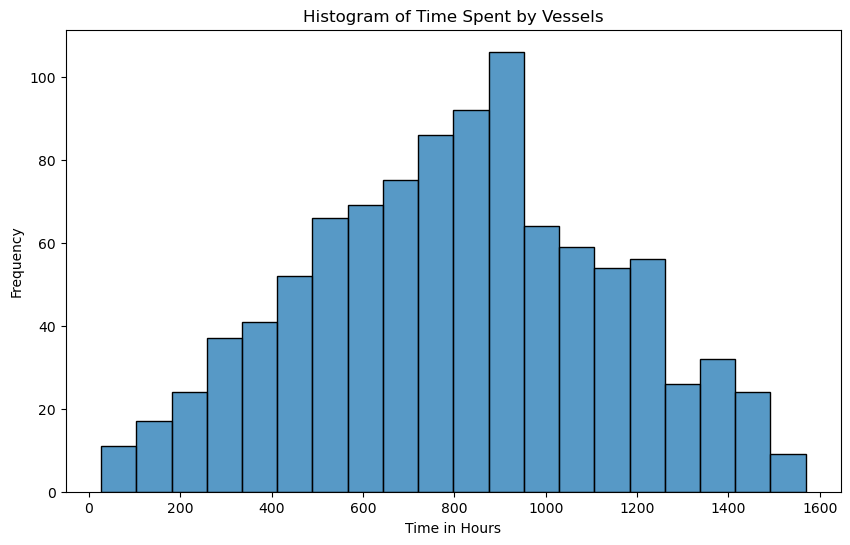

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df_traffic_control['Time_in_Hours'], bins=20)
plt.title('Histogram of Time Spent by Vessels')
plt.xlabel('Time in Hours')
plt.ylabel('Frequency')
plt.show()


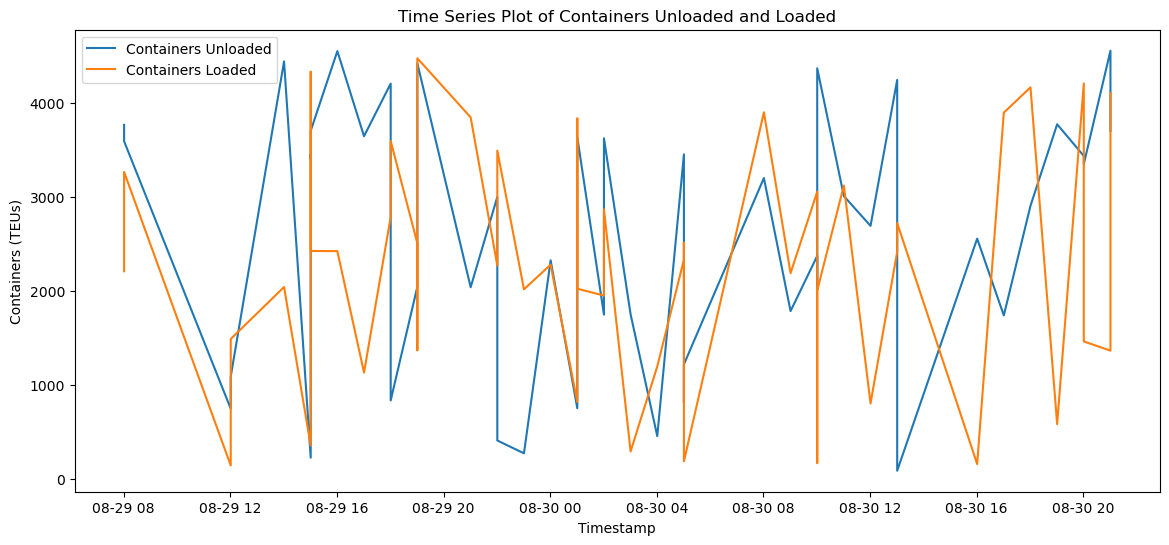

In [4]:
# Sort DataFrame by 'Timestamp_Entry'
df_sorted = df_traffic_control.sort_values('Timestamp_Entry').head(50)  # Taking only first 50 records for better visibility

plt.figure(figsize=(14, 6))
plt.plot(df_sorted['Timestamp_Entry'], df_sorted['Containers_Unloaded (TEUs)'], label='Containers Unloaded', color='tab:blue')
plt.plot(df_sorted['Timestamp_Entry'], df_sorted['Containers_Loaded (TEUs)'], label='Containers Loaded', color='tab:orange')
plt.title('Time Series Plot of Containers Unloaded and Loaded')
plt.xlabel('Timestamp')
plt.ylabel('Containers (TEUs)')
plt.legend()
plt.show()


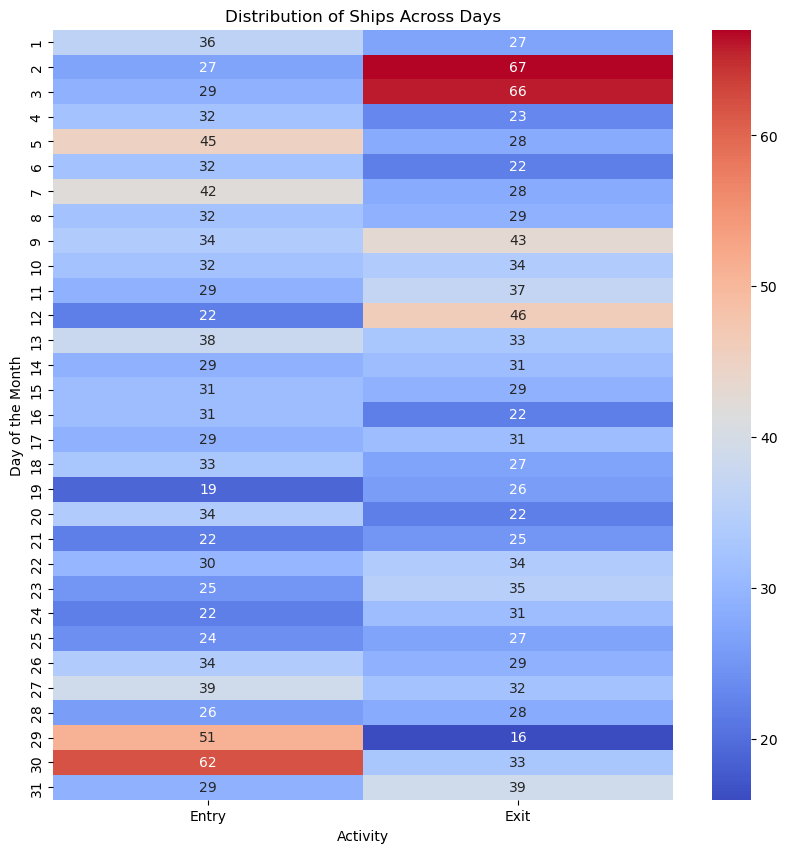

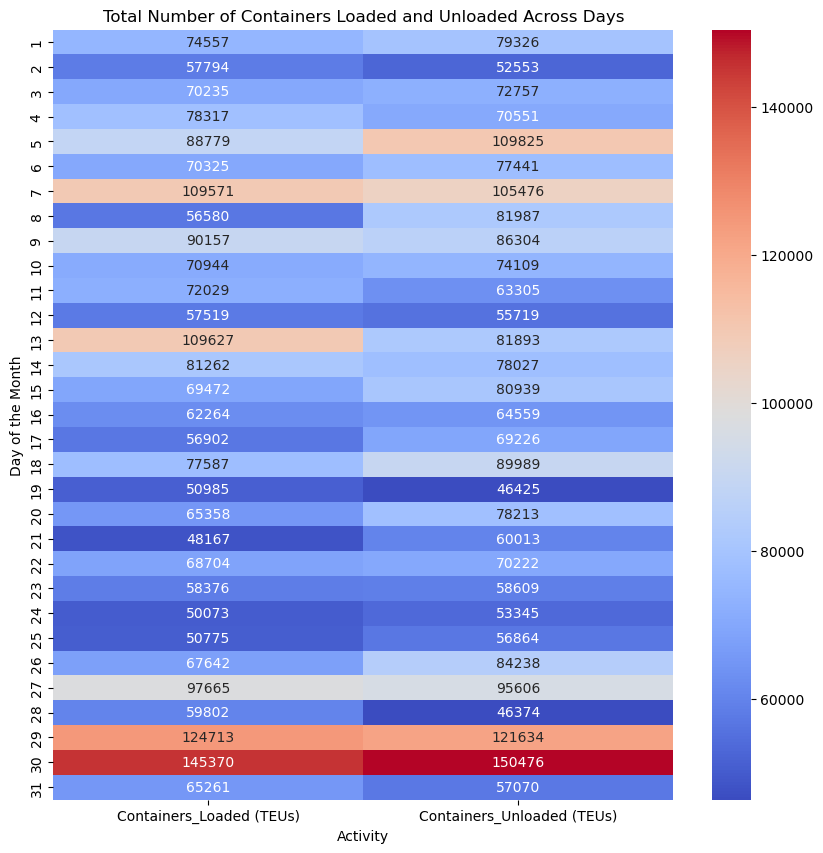

In [5]:
# Count the frequency of ships for each day
entry_day_count = df_traffic_control['Entry_Day'].value_counts().sort_index()
exit_day_count = df_traffic_control['Exit_Day'].value_counts().sort_index()

# Create a DataFrame for the heatmap
df_heatmap_days = pd.DataFrame({
    'Entry': entry_day_count,
    'Exit': exit_day_count
}).fillna(0)

# Distribution of Ships Across Days
plt.figure(figsize=(10, 10))
sns.heatmap(df_heatmap_days, annot=True, cmap='coolwarm', fmt='g')
plt.title('Distribution of Ships Across Days')
plt.xlabel('Activity')
plt.ylabel('Day of the Month')
plt.show()

# Sum the total number of containers for each day
container_day_sum = df_traffic_control.groupby('Entry_Day')[['Containers_Loaded (TEUs)', 'Containers_Unloaded (TEUs)']].sum().sort_index()

# Create a DataFrame for the heatmap
df_heatmap_containers = pd.DataFrame(container_day_sum).fillna(0)

# Total Number of Containers Loaded and Unloaded Across Days
plt.figure(figsize=(10, 10))
sns.heatmap(df_heatmap_containers, annot=True, cmap='coolwarm', fmt='g')
plt.title('Total Number of Containers Loaded and Unloaded Across Days')
plt.xlabel('Activity')
plt.ylabel('Day of the Month')
plt.show()


# ------------------ Demand Forecasting -------------------

In [6]:
# Create a date range for the dataset
start_date = datetime(2020, 1, 1)
end_date = datetime(2021, 12, 31)
date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Create an empty DataFrame to store the mock-up dataset
data = {
    "Month": [],
    "Seasonality": [],
    "MarketTrends": [],
    "Temperature": [],
    "CompetitorPrices": [],
    "Demand": []
}

# Generate data for each date in the date range
num_samples = 25000
for _ in range(num_samples):
    date = np.random.choice(date_range)
    seasonality = np.sin(2 * np.pi * date.month / 12)
    market_trends = seasonality + np.random.uniform(-0.1, 0.1)
    temperature = np.random.uniform(10, 30)
    competitor_prices = 100 + seasonality * 50 + np.random.normal(0, 10)
    demand = 200 - (2 * seasonality) + (3 * market_trends) + (4 * temperature) + (1.5 * competitor_prices) + np.random.normal(0, 20)
    month = date.month
    data["Month"].append(month)
    data["Seasonality"].append(seasonality)
    data["MarketTrends"].append(market_trends)
    data["Temperature"].append(temperature)
    data["CompetitorPrices"].append(competitor_prices)
    data["Demand"].append(demand)

# Create the DataFrame
mockup_dataset = pd.DataFrame(data)

mockup_dataset

,Month,Seasonality,MarketTrends,Temperature,CompetitorPrices,Demand
0,2,0.866025,0.870898,15.989798,139.653906,494.647110
1,3,1.000000,1.018427,22.003539,154.374676,519.732652
2,11,-0.500000,-0.533281,16.346878,64.712992,389.485527
3,5,0.500000,0.463175,15.835004,117.203279,448.816726
4,7,-0.500000,-0.409364,10.264518,93.581005,395.585176
...,...,...,...,...,...,...
24995,4,0.866025,0.957422,15.310850,143.549130,508.665218
24996,3,1.000000,0.902891,21.587191,147.423688,476.801108
24997,8,-0.866025,-0.936552,12.459278,48.257493,357.000272
24998,5,0.500000,0.428228,19.757244,127.210257,493.178458


In [7]:
df_traffic_control.to_csv('df_traffic_control.csv', index=False)
mockup_dataset.to_csv('mockup_dataset.csv', index=False)

Text(0, 0.5, 'Seasonality')

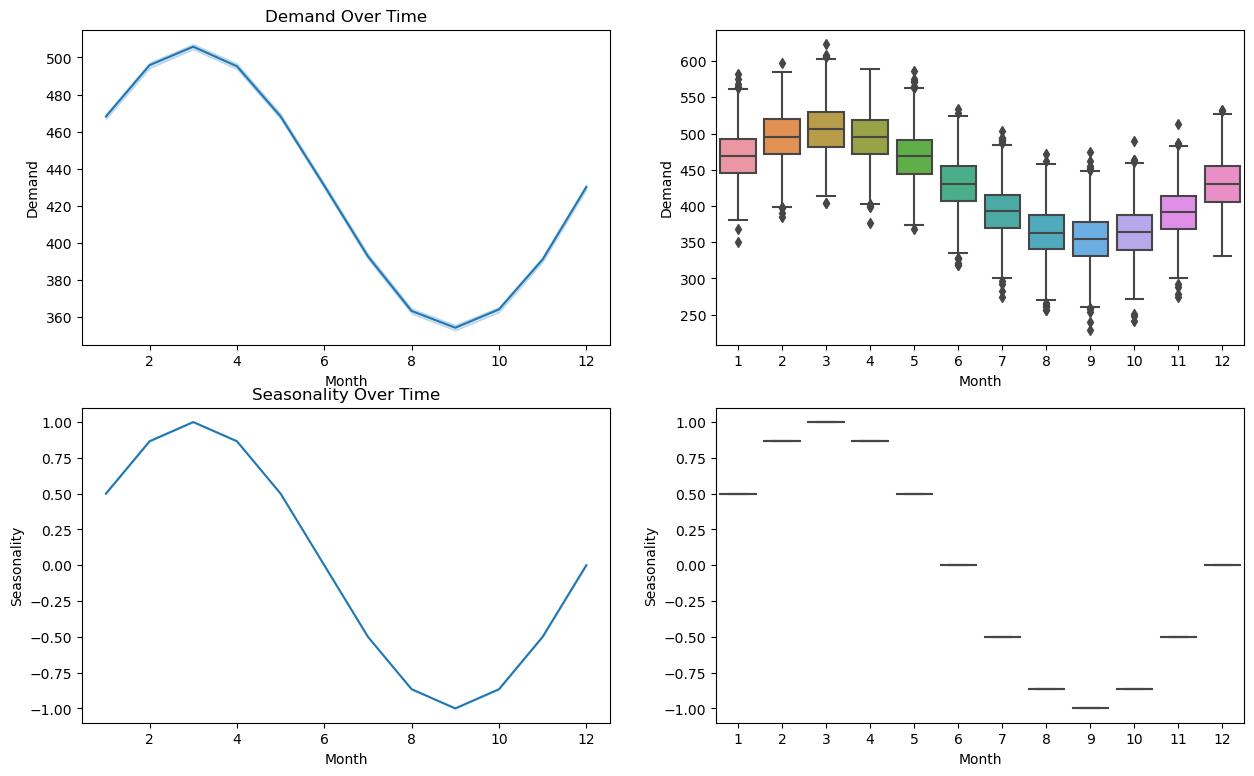

In [8]:
fig, axes = plt.subplots(2,2,figsize=(15,9))

sns.lineplot(x='Month', y='Demand', data=mockup_dataset, ax=axes[0, 0])
axes[0, 0].set_title('Demand Over Time')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Demand')

sns.boxplot(x='Month', y='Demand', data=mockup_dataset, ax=axes[0, 1])
axes[0, 0].set_title('Demand Over Time')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Demand')

sns.lineplot(x='Month', y='Seasonality', data=mockup_dataset, ax=axes[1, 0])
axes[1, 0].set_title('Seasonality Over Time')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Seasonality')

sns.boxplot(x='Month', y='Seasonality', data=mockup_dataset, ax=axes[1, 1])
axes[1, 0].set_title('Seasonality Over Time')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Seasonality')


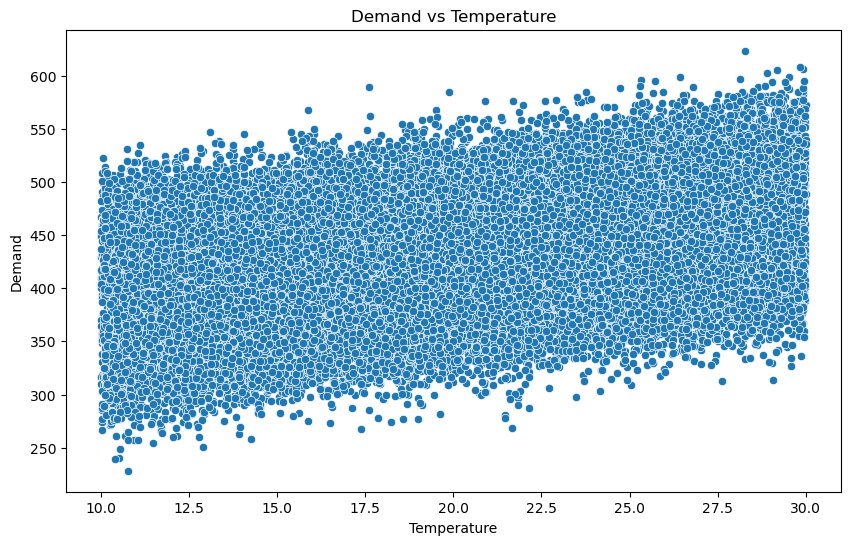

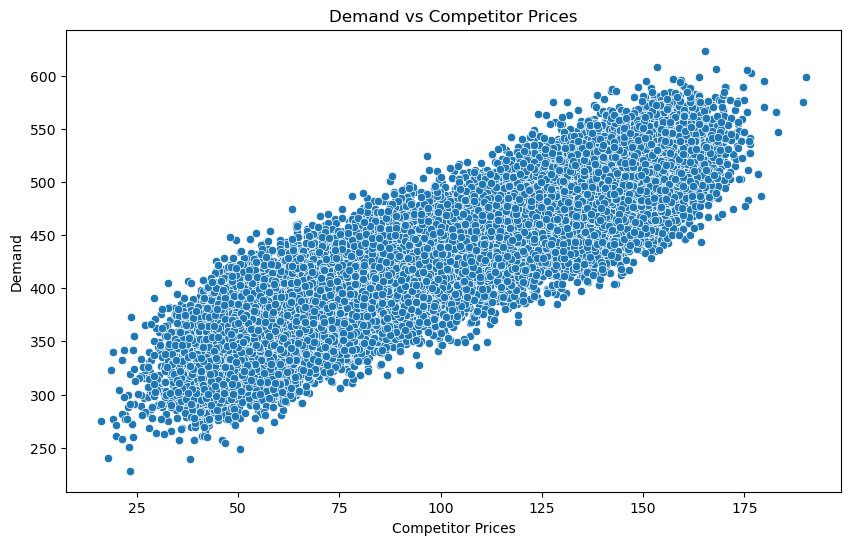

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Demand', data=mockup_dataset)
plt.title('Demand vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitorPrices', y='Demand', data=mockup_dataset)
plt.title('Demand vs Competitor Prices')
plt.xlabel('Competitor Prices')
plt.ylabel('Demand')
plt.show()

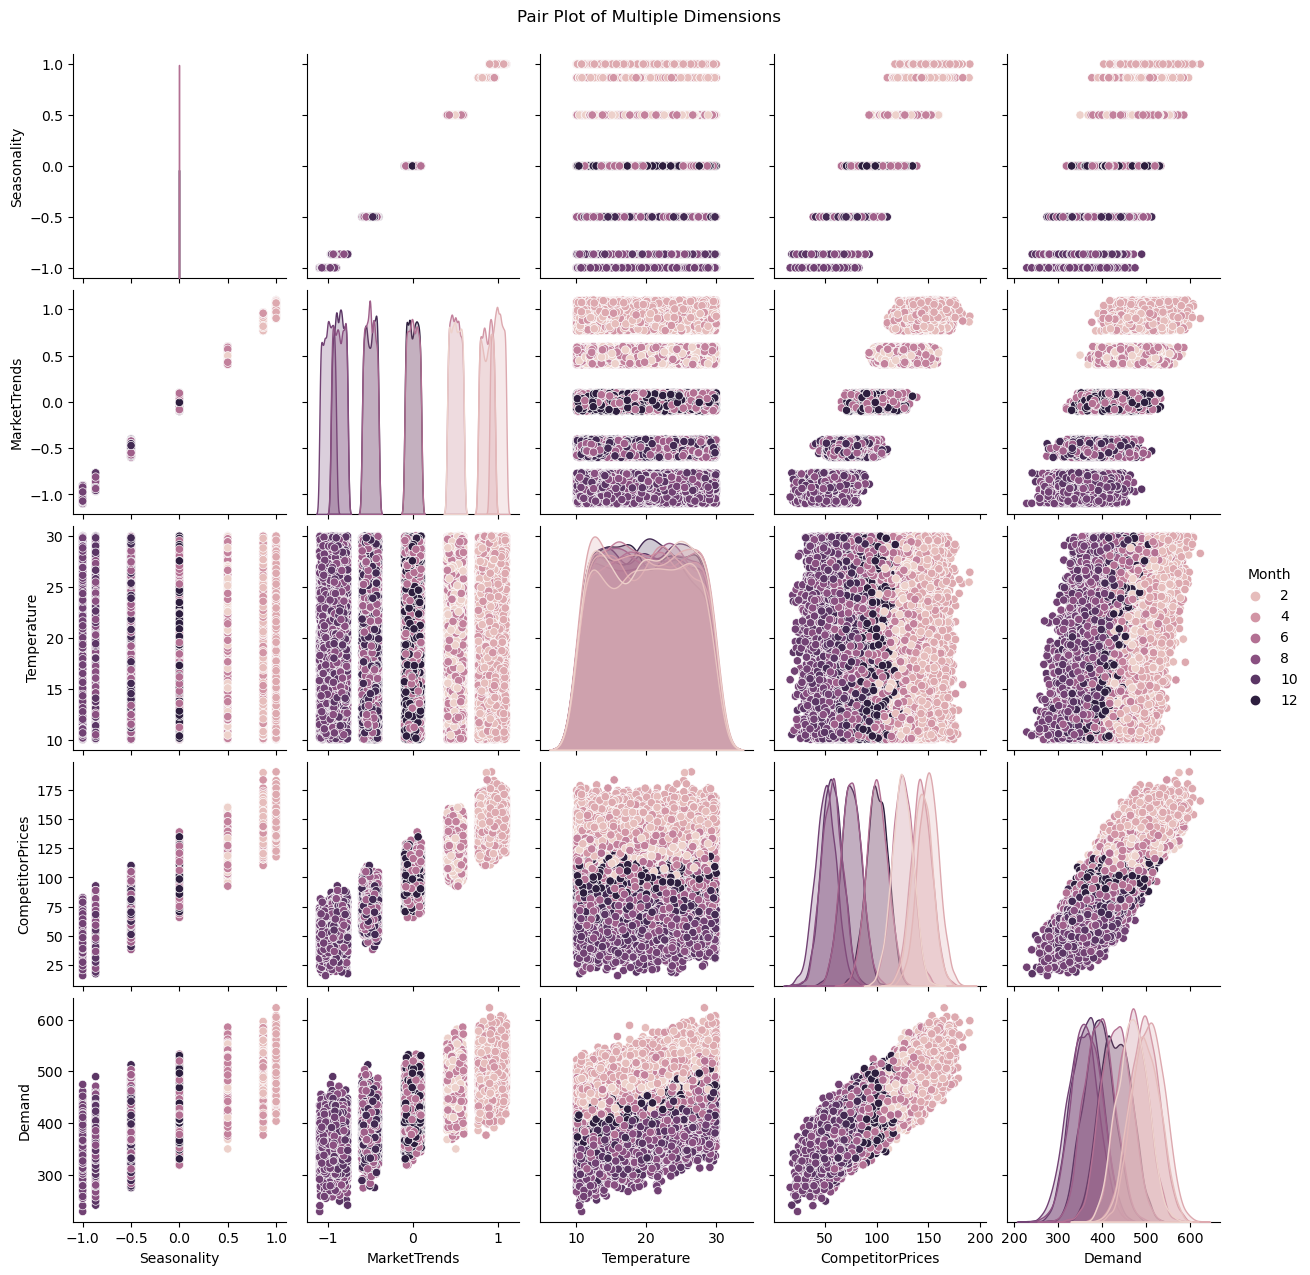

In [10]:
# Create a pair plot
sns.pairplot(mockup_dataset, hue='Month', diag_kind='kde', kind='scatter')
plt.suptitle('Pair Plot of Multiple Dimensions', y=1.02)
plt.show()


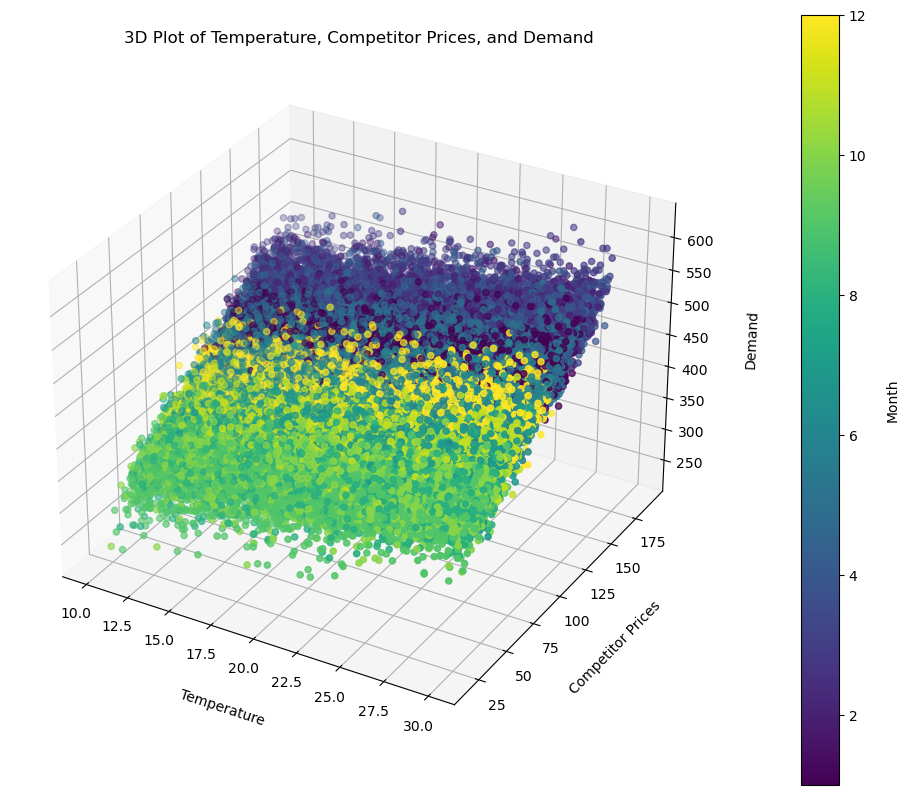

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(mockup_dataset['Temperature'], mockup_dataset['CompetitorPrices'], mockup_dataset['Demand'], c=mockup_dataset['Month'], cmap='viridis')

# Set labels and title
ax.set_xlabel('Temperature', labelpad=14)
ax.set_ylabel('Competitor Prices', labelpad=14)
ax.set_zlabel('Demand', labelpad=16)
plt.title('3D Plot of Temperature, Competitor Prices, and Demand')

# Add colorbar as legend
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Month', labelpad=14)

plt.show()


# -------------- Data Preprocessing for Neural Network --------------


In [12]:
# Data Preprocessing
target = "Demand"
features = ["Month", "Seasonality", "MarketTrends", "Temperature", "CompetitorPrices"]
X = mockup_dataset[features].values
y = mockup_dataset[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# -------------- Neural Network Model Definition ------------------------

In [13]:
# Neural Network Model
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the neural network model
input_size = len(features)
hidden_size = 64
output_size = 1
model = FeedForwardNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



# ---------------------- Training and Evaluation ----------------------

In [14]:
# ---------------------- Training Loop ----------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

# ---------------------- Evaluation ----------------------
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

# Convert predictions and ground truth to numpy arrays
y_test_np = y_test_tensor.numpy()

# Evaluate the model
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²) Score: {r2:.4f}")

Mean Absolute Error (MAE): 16.09
R-squared (R²) Score: 0.9007


# ---------------------- Integration ----------------------

In [15]:
# Generate demand forecasts for each month using the trained neural network model
forecasted_demand = []
for month in range(1, 13):
    input_data = torch.tensor([[month] + [random.uniform(-1, 1), random.uniform(-0.1, 0.1), random.uniform(10, 30), random.uniform(50, 150)]], dtype=torch.float32)
    forecast = model(input_data).item()
    forecasted_demand.append(forecast)

# Create a DataFrame for the demand forecasts
months = list(range(1, 13))
demand_df = pd.DataFrame({"Month": months, "Forecasted Demand (TEU)": forecasted_demand})
print(demand_df)
print()

# Use the demand forecast to optimize the number of containers to be loaded/unloaded
# Define the objective function coefficients (for maximizing)
c = [-1, -1]  # Maximize x + y

# Define the inequality constraints (A*x <= b)
A = [[1, 0], [0, 1], [1, 1]]
b = [df_traffic_control['Containers_Unloaded (TEUs)'].max(), df_traffic_control['Containers_Loaded (TEUs)'].max(), sum(forecasted_demand)]

# Solve the linear programming problem
res = linprog(c, A_ub=A, b_ub=b, method='highs')

# Extract and print the results
optimal_unload = res.x[0]
optimal_load = res.x[1]
print(f"Optimal number of containers to unload (TEUs): {optimal_unload}")
print(f"Optimal number of containers to load (TEUs): {optimal_load}")



    Month  Forecasted Demand (TEU)
0       1              7206.754395
1       2              3901.254639
2       3              5874.221191
3       4              5605.851074
4       5              6818.481445
5       6              6937.700195
6       7              5441.900391
7       8              6353.803711
8       9              5481.279297
9      10              4404.794922
10     11              6706.155762
11     12              7615.846680

Optimal number of containers to unload (TEUs): 4578.0
Optimal number of containers to load (TEUs): 4543.0


# ---------------------- Visualization ----------------------

In [16]:
# Number of containers
num_containers = 500

# Create a list of container IDs (e.g., C001, C002, ...)
container_ids = ["C{:03d}".format(i) for i in range(1, num_containers + 1)]

# Generate random capacities for the containers (e.g., between 20 and 100 TEU)
capacities = [random.randint(20, 100) for _ in range(num_containers)]

# Generate random shipping status for the containers (0 for not shipping, 1 for shipping)
shipping_status = [random.choice([0, 1]) for _ in range(num_containers)]

# Create a DataFrame for the supply dataset
supply_data = {
    "ContainerID": container_ids,
    "Capacity (TEU)": capacities,
    "Shipping Status": shipping_status
}

supply_df = pd.DataFrame(supply_data)
supply_df

,ContainerID,Capacity (TEU),Shipping Status
0,C001,40,1
1,C002,80,1
2,C003,97,1
3,C004,23,1
4,C005,76,0
...,...,...,...
495,C496,80,1
496,C497,69,1
497,C498,97,1
498,C499,53,0


In [17]:
# Create a list to store allocation DataFrames for each month
allocation_dfs = []

# Iterate through each month and allocate containers to meet demand
for _, demand_row in demand_df.iterrows():
    month = demand_row["Month"]
    demand = demand_row["Forecasted Demand (TEU)"]

    # Create a copy of the supply dataset for this month
    allocation_df = supply_df.copy()
    allocation_df["Allocated (TEU)"] = 0  # Initialize the allocated column

    # Filter containers to include only those with Shipping Status equal to 1
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    
    # Shuffle the eligible containers randomly for each month
    eligible_containers = eligible_containers.sample(frac=1)
    
    # Create a list to store allocated container IDs for this month
    allocated_container_ids = []
    
    # Allocate containers to meet demand for the current month
    for _, container_row in eligible_containers.iterrows():
        capacity = container_row["Capacity (TEU)"]
        container_id = container_row["ContainerID"]

        if demand >= capacity:
            allocation_df.at[_, "Allocated (TEU)"] = capacity
            demand -= capacity
            allocated_container_ids.append(container_id)  # Add allocated container ID to the list
        else:
            allocation_df.at[_, "Allocated (TEU)"] = demand
            demand = 0
            allocated_container_ids.append(container_id)  # Add allocated container ID to the list

        if demand == 0:
            break

    # Append the allocation DataFrame to the list
    allocation_dfs.append(allocation_df)

    # Print the allocated container IDs for this month
    print(f"Allocated Container IDs for {month}: {', '.join(allocated_container_ids)}")
    print("\n")
    
    # Print detailed information of allocated containers for this month
    print(f"Detailed Information of Allocated Containers for {month}:")
    allocated_containers_info = allocation_df[allocation_df["ContainerID"].isin(allocated_container_ids)]
    print(allocated_containers_info)
    print("\n")

# Print detailed information of allocated containers
print("Detailed Information of All Allocated Containers:")
allocated_containers_info = supply_df[supply_df["ContainerID"].isin(allocated_container_ids)]
print(allocated_containers_info)

Allocated Container IDs for 1.0: C080, C113, C427, C172, C315, C467, C007, C422, C497, C163, C087, C367, C154, C479, C300, C264, C141, C295, C265, C051, C276, C244, C146, C356, C440, C225, C449, C217, C024, C039, C316, C211, C434, C474, C462, C022, C213, C196, C008, C186, C055, C347, C015, C178, C035, C339, C192, C025, C445, C332, C372, C158, C281, C478, C189, C046, C059, C351, C328, C350, C486, C026, C448, C288, C302, C230, C081, C496, C500, C073, C296, C033, C038, C173, C282, C133, C362, C078, C398, C181, C359, C088, C383, C212, C100, C435, C145, C257, C466, C062, C111, C083, C157, C079, C134, C207, C152, C321, C284, C164, C443, C447, C103, C267, C323, C099, C364, C156, C067, C092, C102, C336, C482, C471, C144, C004, C117, C183, C153


Detailed Information of Allocated Containers for 1.0:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
3          C004              23                1             23.0
6          C007              72                1             72.0


Allocated Container IDs for 9.0: C028, C297, C412, C077, C347, C113, C402, C181, C422, C157, C486, C081, C059, C359, C159, C373, C208, C058, C101, C300, C167, C207, C323, C153, C327, C447, C099, C002, C460, C302, C400, C426, C385, C479, C039, C469, C365, C178, C471, C414, C126, C024, C500, C073, C286, C358, C134, C432, C046, C466, C336, C439, C396, C021, C427, C156, C456, C189, C490, C230, C146, C145, C244, C281, C282, C431, C102, C120, C249, C410, C083, C007, C174, C372, C020, C051, C194, C462, C440, C445, C273, C218, C186, C374, C256


Detailed Information of Allocated Containers for 9.0:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
1          C002              80                1             80.0
6          C007              72                1             72.0
19         C020              35                1             35.0
20         C021             100                1            100.0
23         C024              36                1             36.0
..    

# ---------------------- Final Metrics and Outputs ----------------------

In [18]:
# Print or save the final metrics and outputs
print(f"Mean Absolute Error (MAE) for Demand Forecasting: {mae:.2f}")
print(f"R-squared (R²) Score for Demand Forecasting: {r2:.4f}")
print(f"Optimal number of containers to unload (TEUs): {optimal_unload}")
print(f"Optimal number of containers to load (TEUs): {optimal_load}")

Mean Absolute Error (MAE) for Demand Forecasting: 16.09
R-squared (R²) Score for Demand Forecasting: 0.9007
Optimal number of containers to unload (TEUs): 4578.0
Optimal number of containers to load (TEUs): 4543.0


# ---------------------- Dynamic Allocation ----------------------


In [19]:
# Function to allocate containers based on real-time demand
def allocate_containers(demand, supply_df):
    allocation_df = supply_df.copy()
    allocation_df["Allocated (TEU)"] = 0
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    eligible_containers = eligible_containers.sample(frac=1)
    for _, container_row in eligible_containers.iterrows():
        capacity = container_row["Capacity (TEU)"]
        if demand >= capacity:
            allocation_df.at[_, "Allocated (TEU)"] = capacity
            demand -= capacity
        else:
            allocation_df.at[_, "Allocated (TEU)"] = demand
            demand = 0
        if demand == 0:
            break
    return allocation_df

# ---------------------- Priority Queue ----------------------
# Sort vessels by cargo size and time of arrival
sorted_vessels = df_traffic_control.sort_values(by=['Containers_Loaded (TEUs)', 'Timestamp_Entry'], ascending=[False, True])


In [20]:
# ---------------------- Yard Utilization ----------------------
# Function to optimize yard space
def optimize_yard_space(allocation_df):
    # Assuming each stack can hold 10 containers
    max_stack_height = 10
    stacks = []
    for _, row in allocation_df.iterrows():
        allocated = row["Allocated (TEU)"]
        if allocated > 0:
            placed = False
            for stack in stacks:
                if sum(stack) + allocated <= max_stack_height:
                    stack.append(allocated)
                    placed = True
                    break
            if not placed:
                stacks.append([allocated])
    return stacks

In [21]:
# Create a dictionary to map month numbers to their names
month_names = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}

# Create a list to store allocation DataFrames for each day of the year
allocation_dfs = []

# Create a dictionary to track the shipping status of containers
container_shipping_status = {}

# Iterate through each month
for _, demand_row in demand_df.iterrows():
    month = demand_row["Month"]
    demand = demand_row["Forecasted Demand (TEU)"]

    # Create a copy of the supply dataset for this month
    allocation_df = supply_df.copy()
    allocation_df["Allocated (TEU)"] = 0  # Initialize the allocated column

    # Filter containers to include only those with Shipping Status equal to 1
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    
    # Shuffle the eligible containers randomly for each month
    eligible_containers = eligible_containers.sample(frac=1)
    
    # Calculate daily allocation
    daily_allocation = demand / 31  # Divide monthly demand by the number of days in the month
    
    allocated_container_ids = []
    # Filter containers with shipping status equal to 0 and add their IDs to allocated_container_ids
    for idx, status in enumerate(shipping_status):
        if status == 0:
            allocated_container_ids.append(container_ids[idx])
    
    # Allocate containers to meet demand for each day of the current month
    for day in range(1, 32):
        
        # Reset daily demand to the calculated daily allocation
        daily_demand = daily_allocation
        
        # Create a list to store allocated container IDs for this day
        # Create a list to store allocated container IDs with shipping status equal to 0
        # Filter out already allocated containers from eligible containers
        eligible_containers = eligible_containers[~eligible_containers["ContainerID"].isin(allocated_container_ids)]
        
        allocated_container_ids = []
        
        for _, container_row in eligible_containers.iterrows():
            container_id = container_row["ContainerID"]
            
            capacity = container_row["Capacity (TEU)"]

            if daily_demand >= capacity:
                allocation_df.at[_, "Allocated (TEU)"] = capacity
                daily_demand -= capacity
                allocated_container_ids.append(container_id)  # Add allocated container ID to the list
                
                # Set the shipping status of the container to 0
                container_shipping_status[container_id] = 20  # Set to 20 days (unavailable for 20 days)
            else:
                allocation_df.at[_, "Allocated (TEU)"] = daily_demand
                daily_demand = 0
                allocated_container_ids.append(container_id)  # Add allocated container ID to the list
                
                # Set the shipping status of the container to 0
                container_shipping_status[container_id] = 20  # Set to 20 days (unavailable for 20 days)

            if daily_demand == 0:
                break
        
        # Decrement the shipping status of containers that were unavailable
        for container_id in container_shipping_status:
            if container_shipping_status[container_id] > 0:
                container_shipping_status[container_id] -= 1
        
        # Print detailed information of allocated containers for this day
        print(f"Detailed Information of Allocated Containers for {month}, Day {day}:")
        allocated_containers_info = allocation_df[allocation_df["ContainerID"].isin(allocated_container_ids)]
        print(allocated_containers_info)
        print("\n")

    # Append the allocation DataFrame for this month to the list
    allocation_dfs.append(allocation_df.copy())

Detailed Information of Allocated Containers for 1.0, Day 1:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
32         C033              49                1        49.000000
110        C111              61                1        61.000000
348        C349              92                1        92.000000
357        C358              81                1        30.475948


Detailed Information of Allocated Containers for 1.0, Day 2:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
19         C020              35                1        35.000000
249        C250              58                1        58.000000
263        C264              61                1        61.000000
447        C448              39                1        39.000000
473        C474              86                1        39.475948


Detailed Information of Allocated Containers for 1.0, Day 3:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
23         C024      

Detailed Information of Allocated Containers for 2.0, Day 1:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
224        C225              98                1        35.846924
455        C456              90                1        90.000000


Detailed Information of Allocated Containers for 2.0, Day 2:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
72         C073              76                1        60.846924
427        C428              65                1        65.000000


Detailed Information of Allocated Containers for 2.0, Day 3:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
91         C092              97                1        97.000000
349        C350              46                1        28.846924


Detailed Information of Allocated Containers for 2.0, Day 4:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
123        C124              61                1        61.000000
367        C368         

Detailed Information of Allocated Containers for 3.0, Day 7:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
64         C065              42                1        42.000000
97         C098              62                1        62.000000
141        C142              84                1        25.491006
177        C178              60                1        60.000000


Detailed Information of Allocated Containers for 3.0, Day 8:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
100        C101              93                1        93.000000
132        C133              74                1        74.000000
399        C400              78                1        22.491006


Detailed Information of Allocated Containers for 3.0, Day 9:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
98         C099              73                1        73.000000
108        C109              68                1        68.000000
191        C192      

Detailed Information of Allocated Containers for 4.0, Day 13:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
58         C059              99                1        84.833906
350        C351              96                1        96.000000


Detailed Information of Allocated Containers for 4.0, Day 14:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
20         C021             100                1        32.833906
21         C022              85                1        85.000000
266        C267              63                1        63.000000


Detailed Information of Allocated Containers for 4.0, Day 15:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
97         C098              62                1        41.833906
143        C144              67                1        67.000000
161        C162              52                1        52.000000
172        C173              20                1        20.000000


Detailed Informa

    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
37         C038              24                1        24.000000
57         C058              55                1        55.000000
177        C178              60                1        60.000000
327        C328              85                1        56.951014
355        C356              24                1        24.000000


Detailed Information of Allocated Containers for 5.0, Day 24:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
55         C056              71                1        33.951014
110        C111              61                1        61.000000
191        C192              41                1        41.000000
243        C244              84                1        84.000000


Detailed Information of Allocated Containers for 5.0, Day 25:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
87         C088              22                1        21.951014
166        C16

Detailed Information of Allocated Containers for 7.0, Day 23:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
101        C102              35                1        15.545174
335        C336              50                1        50.000000
397        C398              24                1        24.000000
426        C427              86                1        86.000000


Detailed Information of Allocated Containers for 7.0, Day 24:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
31         C032              47                1        47.000000
168        C169              22                1        22.000000
186        C187              27                1        16.545174
206        C207              49                1        49.000000
340        C341              41                1        41.000000


Detailed Information of Allocated Containers for 7.0, Day 25:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
1          C002   

Detailed Information of Allocated Containers for 8.0, Day 25:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
257        C258              66                1         24.96141
346        C347              80                1         80.00000
388        C389             100                1        100.00000


Detailed Information of Allocated Containers for 8.0, Day 26:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
54         C055              93                1         93.00000
249        C250              58                1         22.96141
395        C396              89                1         89.00000


Detailed Information of Allocated Containers for 8.0, Day 27:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
224        C225              98                1         54.96141
301        C302              89                1         89.00000
468        C469              61                1         61.00000


Detailed Informa

Detailed Information of Allocated Containers for 10.0, Day 1:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
79         C080              20                1        20.000000
163        C164              77                1         9.090159
281        C282              86                1        86.000000
485        C486              27                1        27.000000


Detailed Information of Allocated Containers for 10.0, Day 2:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
3          C004              23                1        23.000000
45         C046              55                1        27.090159
348        C349              92                1        92.000000


Detailed Information of Allocated Containers for 10.0, Day 3:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
224        C225              98                1         7.090159
257        C258              66                1        66.000000
338        C339   

    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
20         C021             100                1        95.327605
182        C183              52                1        52.000000
216        C217              25                1        25.000000
315        C316              44                1        44.000000


Detailed Information of Allocated Containers for 11.0, Day 7:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
23         C024              36                1        36.000000
71         C072              99                1        51.327605
261        C262              54                1        54.000000
280        C281              75                1        75.000000


Detailed Information of Allocated Containers for 11.0, Day 8:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
64         C065              42                1        42.000000
326        C327              45                1         0.327605
363        C36

In [22]:
# Initialize empty lists to store data for DataFrames
monthly_stats_list = []
container_utilization_list = []
shipping_status_stats_list = []

# ---------------------- Monthly Analysis ----------------------
for month, allocation_df in enumerate(allocation_dfs, start=1):
    total_allocated = allocation_df['Allocated (TEU)'].sum()
    avg_daily_allocated = total_allocated / 31  # Assuming all months have 31 days for simplicity
    monthly_stats_list.append({
        'Month': month_names[month],
        'Total Allocated (TEU)': total_allocated,
        'Avg Daily Allocation (TEU)': avg_daily_allocated
    })

# Create DataFrame for Monthly Allocation Statistics
monthly_stats = pd.DataFrame(monthly_stats_list)
print("Monthly Allocation Statistics:")
print(monthly_stats)

Monthly Allocation Statistics:
   Month  Total Allocated (TEU)  Avg Daily Allocation (TEU)
0    Jan            7206.754395                  232.475948
1    Feb            3901.254639                  125.846924
2    Mar            5874.221191                  189.491006
3    Apr            5605.851074                  180.833906
4    May            6818.481445                  219.951014
5    Jun            6937.700195                  223.796780
6    Jul            5441.900391                  175.545174
7    Aug            6353.803711                  204.961410
8    Sep            5481.279297                  176.815461
9    Oct            4404.794922                  142.090159
10   Nov            6706.155762                  216.327605
11   Dec            7615.846680                  245.672474


In [23]:
# ---------------------- Container Utilization ----------------------
for container_id in container_ids:
    utilization_days = sum(df['ContainerID'] == container_id for df in allocation_dfs)
    container_utilization_list.append({
        'ContainerID': container_id,
        'Utilization Days': utilization_days
    })

# Create DataFrame for Container Utilization Statistics
container_utilization = pd.DataFrame(container_utilization_list)
print("Container Utilization Statistics:")
print(container_utilization)

Container Utilization Statistics:
    ContainerID                                   Utilization Days
0          C001  0      12
1       0
2       0
3       0
4     ...
1          C002  0       0
1      12
2       0
3       0
4     ...
2          C003  0       0
1       0
2      12
3       0
4     ...
3          C004  0       0
1       0
2       0
3      12
4     ...
4          C005  0       0
1       0
2       0
3       0
4     ...
..          ...                                                ...
495        C496  0       0
1       0
2       0
3       0
4     ...
496        C497  0       0
1       0
2       0
3       0
4     ...
497        C498  0       0
1       0
2       0
3       0
4     ...
498        C499  0       0
1       0
2       0
3       0
4     ...
499        C500  0       0
1       0
2       0
3       0
4     ...

[500 rows x 2 columns]


In [24]:
# ---------------------- Shipping Status Analysis ----------------------
for container_id, days in container_shipping_status.items():
    shipping_status_stats_list.append({
        'ContainerID': container_id,
        'Days Unavailable': days
    })

# Create DataFrame for Shipping Status Statistics
shipping_status_stats = pd.DataFrame(shipping_status_stats_list)
print("Shipping Status Statistics:")
print(shipping_status_stats)

# You can also visualize these statistics using plots for better understanding.


Shipping Status Statistics:
    ContainerID  Days Unavailable
0          C349                 0
1          C033                 0
2          C111                 0
3          C358                 0
4          C448                 0
..          ...               ...
245        C055                 0
246        C483                 0
247        C008                 8
248        C172                15
249        C048                 0

[250 rows x 2 columns]


In [25]:
# Create a dictionary to map month names to their numbers
month_numbers = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}

# Define a function to perform allocation and forecasting for a specific month
def allocate_and_forecast(month, seasonality, market_trends, temperature, competitor_prices):
    # Get the month number from its name
    month_num = int(month)
    
    # Check if the month number is valid
    if month_num < 1 or month_num > 12:
        print("Invalid month input. Please enter a number between 1 and 12.")
        return
    
    # Convert input features to a PyTorch tensor
    input_data = torch.tensor([[month_num, seasonality, market_trends, temperature, competitor_prices]], dtype=torch.float32)
    
    # Use the trained model to forecast demand for the specified month
    forecasted_demand = model(input_data).item()
    print(f"Forecasted Demand for {month}: {forecasted_demand:.2f} TEU")
    
    # Create a copy of the supply dataset for this month
    allocation_df = supply_df.copy()
    allocation_df["Allocated (TEU)"] = 0  # Initialize the allocated column

    # Filter containers to include only those with Shipping Status equal to 1
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    
    # Shuffle the eligible containers randomly for each month
    eligible_containers = eligible_containers.sample(frac=1)
    
    # Calculate daily allocation
    daily_allocation = forecasted_demand / 31  # Divide monthly demand by the number of days in the month
    
    allocated_container_ids = []
    # Filter containers with shipping status equal to 0 and add their IDs to allocated_container_ids
    for idx, status in enumerate(shipping_status):
        if status == 0:
            allocated_container_ids.append(container_ids[idx])
    
    # Allocate containers to meet demand for each day of the current month
    for day in range(1, 32):
        
        # Reset daily demand to the calculated daily allocation
        daily_demand = daily_allocation
        
        # Filter out already allocated containers from eligible containers
        eligible_containers = eligible_containers[~eligible_containers["ContainerID"].isin(allocated_container_ids)]
        
        # Create a list to store allocated container IDs for this day
        allocated_container_ids = []
        
        for _, container_row in eligible_containers.iterrows():
            container_id = container_row["ContainerID"]
            
            capacity = container_row["Capacity (TEU)"]

            if daily_demand >= capacity:
                allocation_df.at[_, "Allocated (TEU)"] = capacity
                daily_demand -= capacity
                allocated_container_ids.append(container_id)  # Add allocated container ID to the list
                
                # Set the shipping status of the container to 0
                container_shipping_status[container_id] = 20  # Set to 20 days (unavailable for 20 days)
            else:
                allocation_df.at[_, "Allocated (TEU)"] = daily_demand
                daily_demand = 0
                allocated_container_ids.append(container_id)  # Add allocated container ID to the list
                
                # Set the shipping status of the container to 0
                container_shipping_status[container_id] = 20  # Set to 20 days (unavailable for 20 days)

            if daily_demand == 0:
                break
        
        # Decrement the shipping status of containers that were unavailable
        for container_id in container_shipping_status:
            if container_shipping_status[container_id] > 0:
                container_shipping_status[container_id] -= 1
        
        # Print detailed information of allocated containers for this day
        print(f"Detailed Information of Allocated Containers for {month}, Day {day}:")
        allocated_containers_info = allocation_df[allocation_df["ContainerID"].isin(allocated_container_ids)]
        print(allocated_containers_info)
        print("\n")

# Interactive input
month = int(input("Enter the month (e.g., '1-12'): "))
seasonality = float(input("Enter the seasonality factor: "))
market_trends = float(input("Enter the market trends factor: "))
temperature = float(input("Enter the temperature: "))
competitor_prices = float(input("Enter the competitor prices: "))

# Call the allocate_and_forecast function with user input
allocate_and_forecast(month, seasonality, market_trends, temperature, competitor_prices)

Enter the month (e.g., '1-12'): 1
Enter the seasonality factor: 0.5
Enter the market trends factor: 0.9
Enter the temperature: 20
Enter the competitor prices: 180
Forecasted Demand for 1: 10777.43 TEU
Detailed Information of Allocated Containers for 1, Day 1:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
19         C020              35                1         35.00000
86         C087              51                1         51.00000
99         C100              48                1         48.00000
118        C119              66                1         28.65918
123        C124              61                1         61.00000
191        C192              41                1         41.00000
451        C452              83                1         83.00000


Detailed Information of Allocated Containers for 1, Day 2:
    ContainerID  Capacity (TEU)  Shipping Status  Allocated (TEU)
21         C022              85                1         68.65918
34         C035    

In [26]:
# Enter the month (e.g., '1-12'): 1
# Enter the seasonality factor: 0.18
# Enter the market trends factor: 0.55
# Enter the temperature: 27
# Enter the competitor prices: 50

SyntaxError: invalid syntax (1267340919.py, line 1)

In [ ]:
## Constants
DAYS_IN_MONTH = 31
UNAVAILABLE_DAYS = 20

# Function to forecast demand
def forecast_demand(month, seasonality, market_trends, temperature, competitor_prices):
    input_data = torch.tensor([[month, seasonality, market_trends, temperature, competitor_prices]], dtype=torch.float32)
    return model(input_data).item()

# Function to allocate containers
def allocate_containers(daily_demand, allocation_df, eligible_containers):
    allocated_container_ids = []
    for _, container_row in eligible_containers.iterrows():
        container_id = container_row["ContainerID"]
        capacity = container_row["Capacity (TEU)"]
        if daily_demand >= capacity:
            allocation_df.at[_, "Allocated (TEU)"] = capacity
            daily_demand -= capacity
            allocated_container_ids.append(container_id)
            container_shipping_status[container_id] = UNAVAILABLE_DAYS
        else:
            allocation_df.at[_, "Allocated (TEU)"] = daily_demand
            daily_demand = 0
            allocated_container_ids.append(container_id)
            container_shipping_status[container_id] = UNAVAILABLE_DAYS
        if daily_demand == 0:
            break
    return allocated_container_ids

# Main function to allocate and forecast
def allocate_and_forecast(month, seasonality, market_trends, temperature, competitor_prices):
    if month < 1 or month > 12:
        raise ValueError("Invalid month input. Please enter a number between 1 and 12.")
    
    forecasted_demand = forecast_demand(month, seasonality, market_trends, temperature, competitor_prices)
    print(f"Forecasted Demand for {month_numbers[month]}: {forecasted_demand:.2f} TEU")
    
    allocation_df = supply_df.copy()
    allocation_df["Allocated (TEU)"] = 0
    
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    eligible_containers = eligible_containers.sample(frac=1)
    
    daily_allocation = forecasted_demand / DAYS_IN_MONTH
    
    for day in range(1, DAYS_IN_MONTH + 1):
        daily_demand = daily_allocation
        allocated_container_ids = allocate_containers(daily_demand, allocation_df, eligible_containers)
        
        print(f"Detailed Information of Allocated Containers for {month_numbers[month]}, Day {day}:")
        allocated_containers_info = allocation_df[allocation_df["ContainerID"].isin(allocated_container_ids)]
        print(allocated_containers_info)
        print("\n")

# Interactive input
try:
    month = int(input("Enter the month (e.g., '1-12'): "))
    seasonality = float(input("Enter the seasonality factor: "))
    market_trends = float(input("Enter the market trends factor: "))
    temperature = float(input("Enter the temperature: "))
    competitor_prices = float(input("Enter the competitor prices: "))
    
    allocate_and_forecast(month, seasonality, market_trends, temperature, competitor_prices)
except ValueError as e:
    print(e)